# requiments

In [180]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
import sklearn

import tensorflow as tf
import tensorflow.keras as ks
import statsmodels.api as sm

import yfinance as yf

import warnings

sns.set()
sns.set_style('whitegrid')
# plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (15,7)
plt.rcParams["axes.grid"] =True

warnings.filterwarnings('ignore')

In [181]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [182]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# functions (utils) to use

In [4]:
def plot_candlestick(data):
    fig = go.Figure(data=[
    go.Candlestick(x=data['Date'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])
    fig.show()
    
def plot_ohlc(data):
    fig = go.Figure(data=[
    go.Ohlc(x=data['Date'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])
    fig.show()

In [5]:
def plot_series_analysis(series,name):
    fig = plt.figure(figsize= (15,10))
    gs = fig.add_gridspec(2,2)
    ax = fig.add_subplot(gs[0,:])
    ax_acf = fig.add_subplot(gs[1,0])
    ax_pacf = fig.add_subplot(gs[1,1])
    ax.plot(series)
    ax.set_title(name)
    plot_acf(series,ax=ax_acf)
    plot_pacf(series,ax=ax_pacf)

In [6]:
def plot_data_analysis(data):
    for feature in data.columns:
        if feature!="Date":
            plot_series_analysis(data[feature],feature)

# Data import, EDA, preprocessing

In [35]:
google = yf.Ticker('GOOG')

In [36]:
google_data = google.history(start="2020-01-01", end="2021-05-23", interval="1d")

In [37]:
google_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-12-31,1330.109985,1338.000000,1329.084961,1337.020020,961800,0,0
2020-01-02,1341.550049,1368.140015,1341.550049,1367.369995,1406600,0,0
2020-01-03,1347.859985,1372.500000,1345.543945,1360.660034,1186400,0,0
2020-01-06,1350.000000,1396.500000,1350.000000,1394.209961,1732300,0,0
2020-01-07,1397.939941,1402.989990,1390.380005,1393.339966,1502700,0,0
...,...,...,...,...,...,...,...
2021-05-17,2309.320068,2323.340088,2295.000000,2321.409912,992100,0,0
2021-05-18,2336.906006,2343.149902,2303.159912,2303.429932,865100,0,0
2021-05-19,2264.399902,2316.760010,2263.520020,2308.709961,967500,0,0


Open Price : The Stock at which opens at the start of market

High price : The particular stock which made high during that particular day

Low Price : The Particular stock which made Low during that particular day

Close Price : The stock closing at the end of the Market hours

Volume : The total number of shares traded in a security over a period.

In [38]:
google_data = google_data.drop(["Dividends","Stock Splits"],axis=1)

In [39]:
plot_ohlc(google_data.reset_index())

In [12]:
plot_candlestick(google_data.reset_index())

As we can see, there is a uptrend here, bullish market 

Let's analyse time series

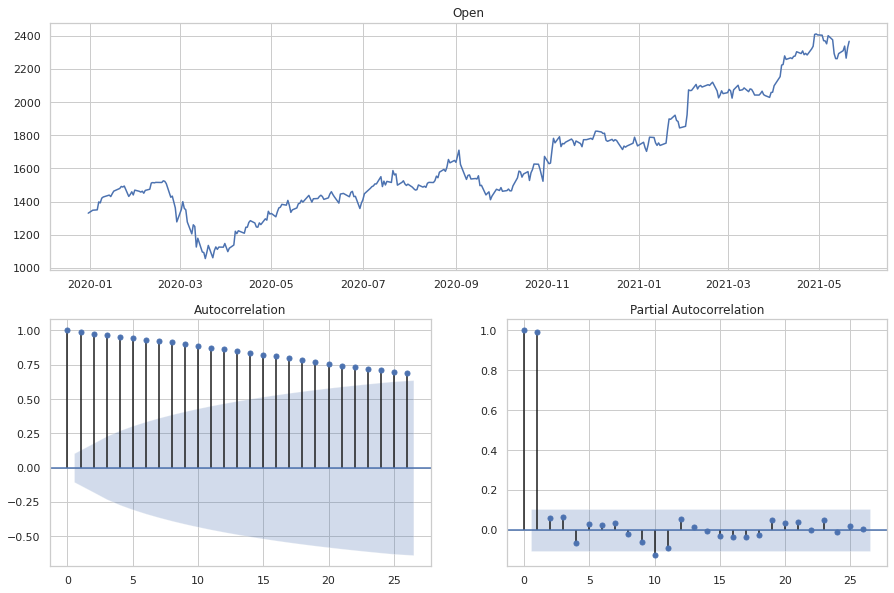

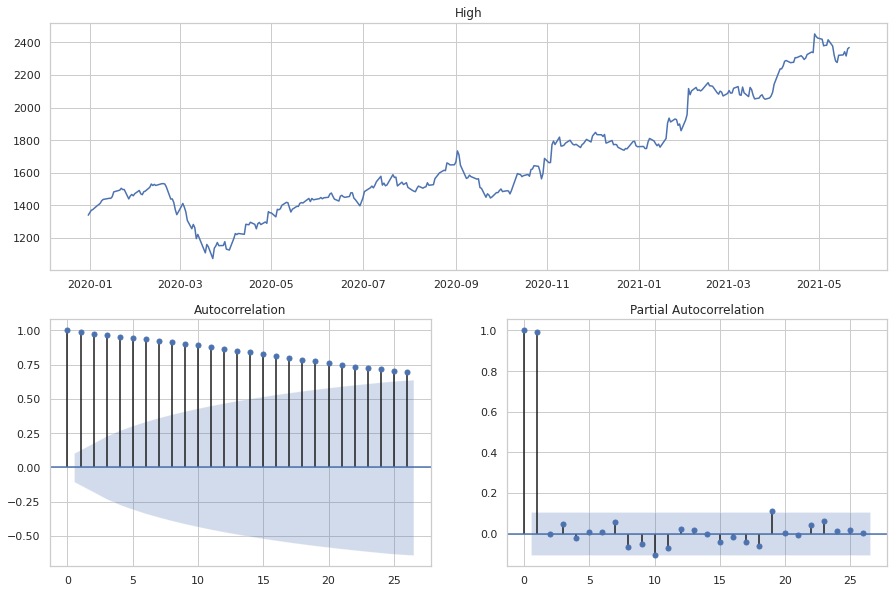

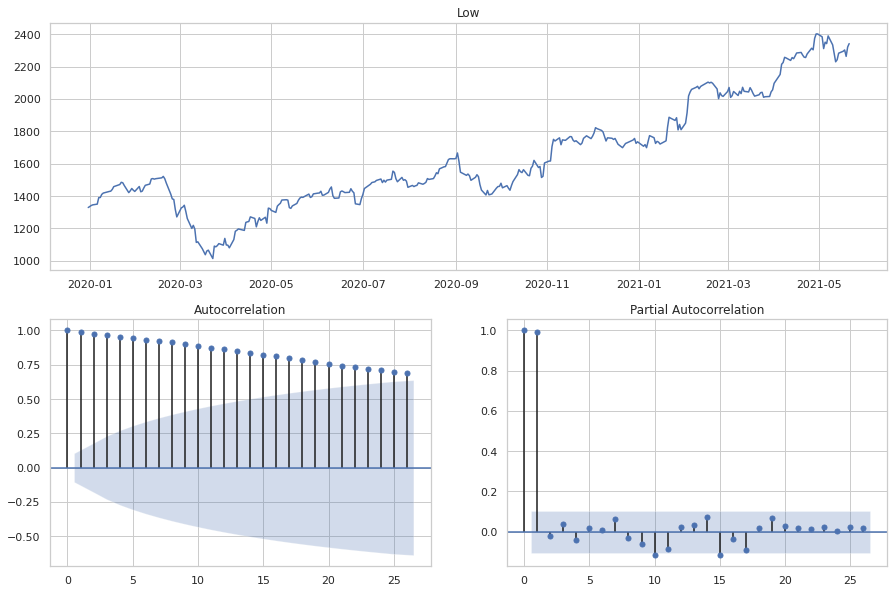

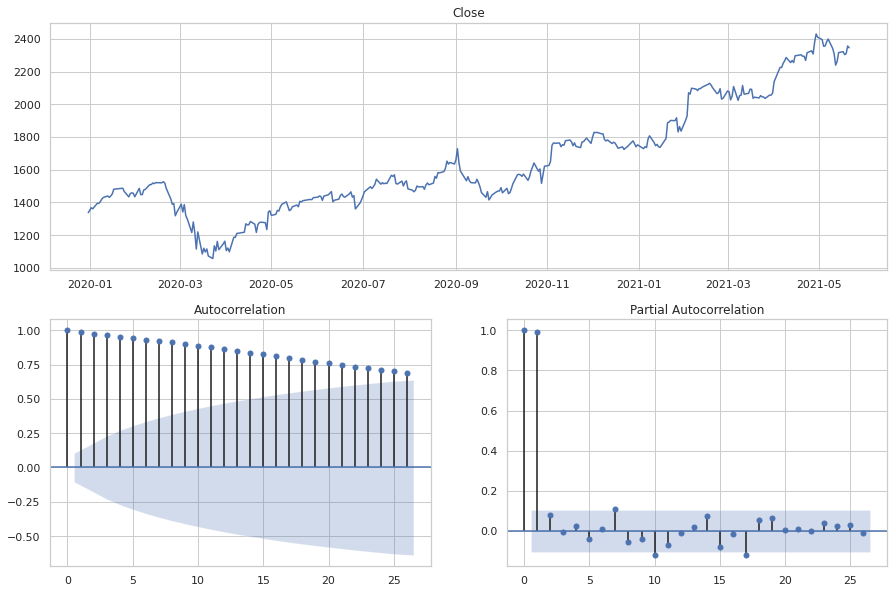

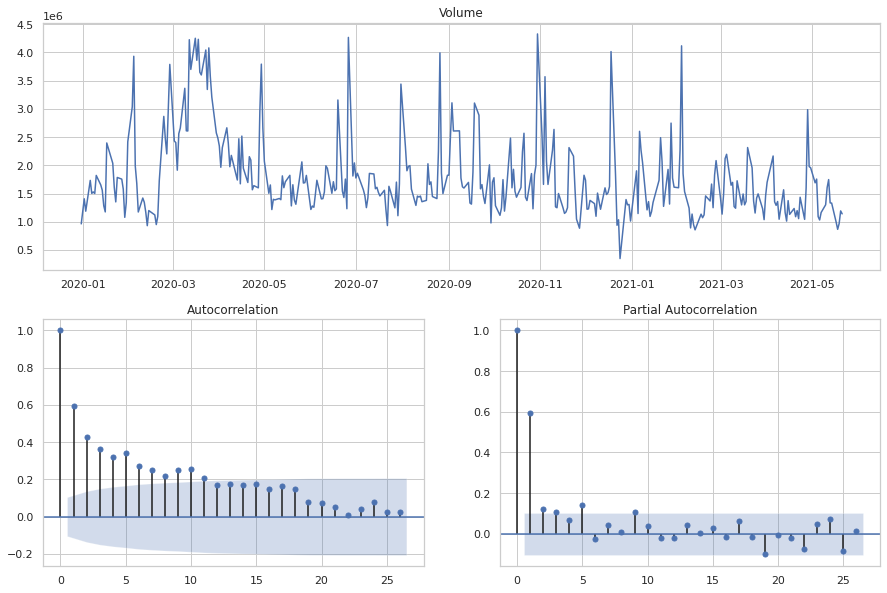

In [13]:
plot_data_analysis(google_data)

Main goal for forecast task will be "Close" price prediction, so we can understand which market now is and which strategy we should use 

In [32]:
# google_data = google_data.diff().iloc[1:]

## Time series train-validation split

In [40]:
data = google_data["Close"].to_numpy()

In [41]:
google_data = google_data.to_numpy()

In [42]:
google_data.shape

(351, 5)

In [43]:
training_len = int(np.ceil(len(data)*0.75))
data_train_val = data[:training_len]
data_test = data[training_len:]

In [44]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler().fit(data_train_val.reshape(1,-1).T)
standard_scaler = sklearn.preprocessing.StandardScaler().fit(data_train_val.reshape(1,-1).T)

In [45]:
data_train_val_sc = min_max_scaler.transform(data_train_val.reshape(1,-1).T)
data_test_sc = min_max_scaler.transform(data_test.reshape(1,-1).T)

In [46]:
data_train_val_sc = data_train_val_sc.flatten()
data_test_sc = data_test_sc.flatten()

In [47]:
def get_windows(data,windows_size = 25):
    if type(data)==pd.Series:
        return  np.lib.stride_tricks.as_strided(data,
                       (len(data)-(windows_size-1), windows_size),
                       (data.values.strides*2))
    if type(data)==np.ndarray:
        return  np.lib.stride_tricks.as_strided(data,
                       (len(data)-(windows_size-1), windows_size),
                       (data.strides*2))
    elif type(data)==pd.DataFrame:
        windowed_data = {}
        for feature in data.columns:
            windowed_data[feature] = get_windows(data[feature],
                                                 windows_size=windows_size)
        return windowed_data

In [48]:
windowed_data_train_val_sc = get_windows(data_train_val_sc,
                                             windows_size=100)

windowed_data_train_val = get_windows(data_train_val.flatten(),
                                      windows_size=100)

In [49]:
x_train_window_size = 25
y_train_window_size = 25
x_val_window_size = 25
y_val_window_size = 25

In [50]:
X_train = windowed_data_train_val_sc[:,:25]
y_train = windowed_data_train_val_sc[:,25:50]
X_val = windowed_data_train_val_sc[:,50:75]
y_val = windowed_data_train_val_sc[:,75:100]

# X_train = windowed_data_train_val[:,:25]
# y_train = windowed_data_train_val[:,25:50]
# X_val = windowed_data_train_val[:,50:75]
# y_val = windowed_data_train_val[:,75:100]

In [51]:
X_train =  np.expand_dims(X_train, axis=-1)
# y_train =  np.expand_dims(y_train, axis=-1)
X_val =  np.expand_dims(X_val, axis=-1)
# y_val =  np.expand_dims(y_val, axis=-1)

In [52]:
X_test = np.expand_dims(get_windows(data_train_val_sc,windows_size=100),axis=-1)
y_test = standard_scaler.transform(data_test.reshape(-1,1))

In [98]:
def preprocess_data(data,windows_size=25):
    return np.expand_dims(
                get_windows(
                    min_max_scaler.transform(
                        data.reshape(-1,1)).flatten(),windows_size=windows_size),axis=1).transpose(0,2,1)

In [115]:
models ={}
histories = {}

# One-layer networks

### RNN

In [53]:
model = ks.Sequential(
    [
        tf.keras.layers.Input((25,1),name="input"),
        tf.keras.layers.SimpleRNN(128,name="rnn"),
        tf.keras.layers.Dense(25, activation='linear',name="dense")
    ]
)

model.compile(loss='mse', optimizer='adam',
                metrics=('mse', 'mae', 'mape'))
model.summary()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    callbacks=(tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                patience=40)),
                    epochs=500,batch_size=16)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (SimpleRNN)              (None, 128)               16640     
_________________________________________________________________
dense (Dense)                (None, 25)                3225      
Total params: 19,865
Trainable params: 19,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 1s 34ms/step - loss: 0.1442 - mse: 0.1442 - mae: 0.3092 - mape: 1479021.0885 - val_loss: 0.0445 - val_mse: 0.0445 - val_mae: 0.1642 - val_mape: 23.3694
Epoch 2/500
11/11 [==============================] - 0s 15ms/step - loss: 0.0386 - mse: 0.0386 - mae: 0.1486 - mape: 3074433.4792 - val_loss: 0.0329 - val_mse: 0.0329 - val_mae: 0.1378 - val_mape: 19.1301
Epoch 3/500
11/11 [==============================] - 0s 16ms/step - loss: 0.0260 - mse: 0.0260 - mae: 

Epoch 38/500
11/11 [==============================] - 0s 16ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.1019 - mape: 2346812.8438 - val_loss: 0.0227 - val_mse: 0.0227 - val_mae: 0.1112 - val_mape: 15.3060
Epoch 39/500
11/11 [==============================] - 0s 16ms/step - loss: 0.0212 - mse: 0.0212 - mae: 0.1043 - mape: 2450840.0833 - val_loss: 0.0167 - val_mse: 0.0167 - val_mae: 0.0955 - val_mape: 13.7267
Epoch 40/500
11/11 [==============================] - 0s 16ms/step - loss: 0.0196 - mse: 0.0196 - mae: 0.0929 - mape: 2033091.7005 - val_loss: 0.0282 - val_mse: 0.0282 - val_mae: 0.1278 - val_mape: 17.9362
Epoch 41/500
11/11 [==============================] - 0s 16ms/step - loss: 0.0182 - mse: 0.0182 - mae: 0.0960 - mape: 1691238.4427 - val_loss: 0.0314 - val_mse: 0.0314 - val_mae: 0.1369 - val_mape: 19.0165
Epoch 42/500
11/11 [==============================] - 0s 16ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.0985 - mape: 1841129.0833 - val_loss: 0.0356 - val_mse: 0.0356 - val_ma

Epoch 78/500
11/11 [==============================] - 0s 16ms/step - loss: 0.0195 - mse: 0.0195 - mae: 0.0940 - mape: 2232333.0938 - val_loss: 0.0229 - val_mse: 0.0229 - val_mae: 0.1130 - val_mape: 15.5941
Epoch 79/500
11/11 [==============================] - 0s 16ms/step - loss: 0.0171 - mse: 0.0171 - mae: 0.0904 - mape: 1839873.5729 - val_loss: 0.0257 - val_mse: 0.0257 - val_mae: 0.1223 - val_mape: 16.9441
Epoch 80/500
11/11 [==============================] - 0s 16ms/step - loss: 0.0193 - mse: 0.0193 - mae: 0.0984 - mape: 2583312.8333 - val_loss: 0.0186 - val_mse: 0.0186 - val_mae: 0.0995 - val_mape: 14.0616
Epoch 81/500
11/11 [==============================] - 0s 16ms/step - loss: 0.0179 - mse: 0.0179 - mae: 0.0933 - mape: 1486834.6510 - val_loss: 0.0195 - val_mse: 0.0195 - val_mae: 0.1015 - val_mape: 14.0851
Epoch 82/500
11/11 [==============================] - 0s 16ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0870 - mape: 1656472.6562 - val_loss: 0.0278 - val_mse: 0.0278 - val_ma

In [116]:
models["one_layer_rnn"] = model
histories["one_layer_rnn"] = history

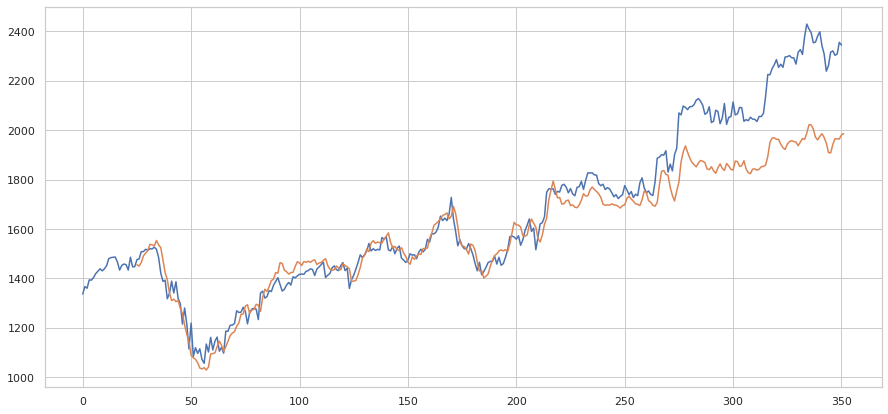

In [113]:
sns.lineplot(x = np.arange(len(data)),y=data)
pred = min_max_scaler.inverse_transform(model.predict(preprocess_data(data))[:,0].reshape(-1,1)).flatten()
sns.lineplot(
    x = np.arange(25,25+len(pred)),
    y = pred)
del pred

### LSTM

In [117]:
model = ks.Sequential(
    [
        tf.keras.layers.Input((25,1),name="input"),
        tf.keras.layers.LSTM(128,name="rnn"),
        tf.keras.layers.Dense(25, activation='linear',name="dense")
    ]
)

model.compile(loss='mse', optimizer='adam',
                metrics=('mse', 'mae', 'mape'))
model.summary()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    callbacks=(tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                patience=40)),
                    epochs=500,batch_size=16)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (LSTM)                   (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 25)                3225      
Total params: 69,785
Trainable params: 69,785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 3s 41ms/step - loss: 0.2046 - mse: 0.2046 - mae: 0.4064 - mape: 452172.9909 - val_loss: 0.0433 - val_mse: 0.0433 - val_mae: 0.1675 - val_mape: 26.6848
Epoch 2/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0420 - mse: 0.0420 - mae: 0.1620 - mape: 2479470.0521 - val_loss: 0.0433 - val_mse: 0.0433 - val_mae: 0.1653 - val_mape: 23.8616
Epoch 3/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0338 - mse: 0.0338 - mae: 0

Epoch 38/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0217 - mse: 0.0217 - mae: 0.1063 - mape: 2471648.0625 - val_loss: 0.0192 - val_mse: 0.0192 - val_mae: 0.1023 - val_mape: 14.2693
Epoch 39/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0192 - mse: 0.0192 - mae: 0.0931 - mape: 2266411.9583 - val_loss: 0.0335 - val_mse: 0.0335 - val_mae: 0.1454 - val_mape: 20.3509
Epoch 40/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0239 - mse: 0.0239 - mae: 0.1203 - mape: 2162890.6146 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1157 - val_mape: 16.1855
Epoch 41/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0212 - mse: 0.0212 - mae: 0.1043 - mape: 2177060.8646 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.1076 - val_mape: 14.8896
Epoch 42/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0182 - mse: 0.0182 - mae: 0.0915 - mape: 1728178.7865 - val_loss: 0.0372 - val_mse: 0.0372 - val_ma

Epoch 78/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0171 - mse: 0.0171 - mae: 0.0918 - mape: 1745649.4167 - val_loss: 0.0186 - val_mse: 0.0186 - val_mae: 0.0981 - val_mape: 13.7534
Epoch 79/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0194 - mse: 0.0194 - mae: 0.0962 - mape: 1886620.3906 - val_loss: 0.0250 - val_mse: 0.0250 - val_mae: 0.1133 - val_mape: 15.4996
Epoch 80/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0174 - mse: 0.0174 - mae: 0.0935 - mape: 2025616.3021 - val_loss: 0.0223 - val_mse: 0.0223 - val_mae: 0.1061 - val_mape: 14.5988
Epoch 81/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0874 - mape: 1655360.7500 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.0998 - val_mape: 14.3763
Epoch 82/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0215 - mse: 0.0215 - mae: 0.0985 - mape: 1999419.4896 - val_loss: 0.0256 - val_mse: 0.0256 - val_ma

Epoch 118/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0118 - mse: 0.0118 - mae: 0.0735 - mape: 1482679.7708 - val_loss: 0.0350 - val_mse: 0.0350 - val_mae: 0.1307 - val_mape: 17.3628
Epoch 119/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0800 - mape: 1199413.9583 - val_loss: 0.0308 - val_mse: 0.0308 - val_mae: 0.1213 - val_mape: 16.1645
Epoch 120/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0814 - mape: 1897098.8958 - val_loss: 0.0178 - val_mse: 0.0178 - val_mae: 0.0932 - val_mape: 13.1226
Epoch 121/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0688 - mape: 1008981.2891 - val_loss: 0.0288 - val_mse: 0.0288 - val_mae: 0.1177 - val_mape: 15.8417
Epoch 122/500
11/11 [==============================] - 0s 11ms/step - loss: 0.0114 - mse: 0.0114 - mae: 0.0721 - mape: 1138437.3490 - val_loss: 0.0203 - val_mse: 0.0203 - v

In [118]:
models["one_layer_lstm"] = model
histories["one_layer_lstm"] = history

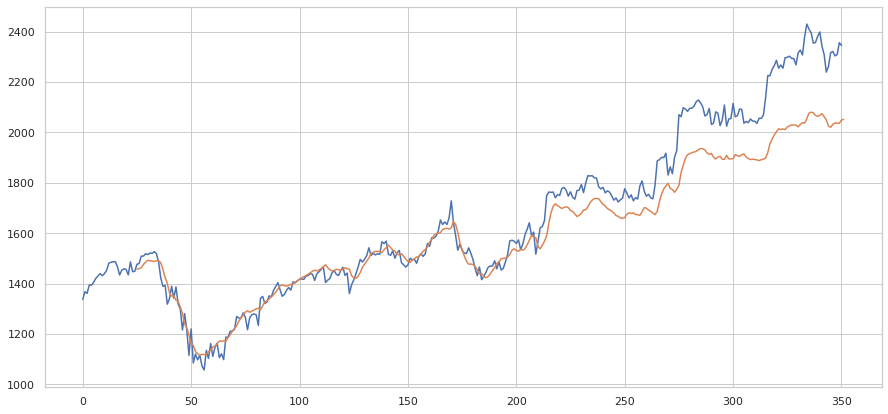

In [119]:
sns.lineplot(x = np.arange(len(data)),y=data)
pred = min_max_scaler.inverse_transform(model.predict(preprocess_data(data))[:,0].reshape(-1,1)).flatten()
sns.lineplot(
    x = np.arange(25,25+len(pred)),
    y = pred)
del pred

### GRU

In [127]:
model = ks.Sequential(
    [
        tf.keras.layers.Input((25,1),name="input"),
        tf.keras.layers.GRU(128,name="rnn"),
        tf.keras.layers.Dense(25, activation='linear',name="dense")
    ]
)

model.compile(loss='mse', optimizer='adam',
                metrics=('mse', 'mae', 'mape'))
model.summary()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    callbacks=(tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                patience=40)),
                    epochs=500,batch_size=16)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (GRU)                    (None, 128)               50304     
_________________________________________________________________
dense (Dense)                (None, 25)                3225      
Total params: 53,529
Trainable params: 53,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 2s 39ms/step - loss: 0.2058 - mse: 0.2058 - mae: 0.4139 - mape: 326188.6172 - val_loss: 0.1966 - val_mse: 0.1966 - val_mae: 0.4049 - val_mape: 61.3794
Epoch 2/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0778 - mse: 0.0778 - mae: 0.2289 - mape: 2034738.2188 - val_loss: 0.0421 - val_mse: 0.0421 - val_mae: 0.1710 - val_mape: 24.4508
Epoch 3/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0285 - mse: 0.0285 - mae: 0

Epoch 38/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0181 - mse: 0.0181 - mae: 0.0934 - mape: 2014840.3542 - val_loss: 0.0233 - val_mse: 0.0233 - val_mae: 0.1140 - val_mape: 15.8488
Epoch 39/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0176 - mse: 0.0176 - mae: 0.0953 - mape: 1682929.8177 - val_loss: 0.0260 - val_mse: 0.0260 - val_mae: 0.1217 - val_mape: 16.9236
Epoch 40/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0197 - mse: 0.0197 - mae: 0.0974 - mape: 2114836.2604 - val_loss: 0.0238 - val_mse: 0.0238 - val_mae: 0.1160 - val_mape: 16.0982
Epoch 41/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0184 - mse: 0.0184 - mae: 0.0948 - mape: 1718918.4062 - val_loss: 0.0245 - val_mse: 0.0245 - val_mae: 0.1177 - val_mape: 16.3530
Epoch 42/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0184 - mse: 0.0184 - mae: 0.0978 - mape: 1871405.0284 - val_loss: 0.0232 - val_mse: 0.0232 - val_mae:

In [128]:
models["one_layer_gru"] = model
histories["one_layer_gru"] = history

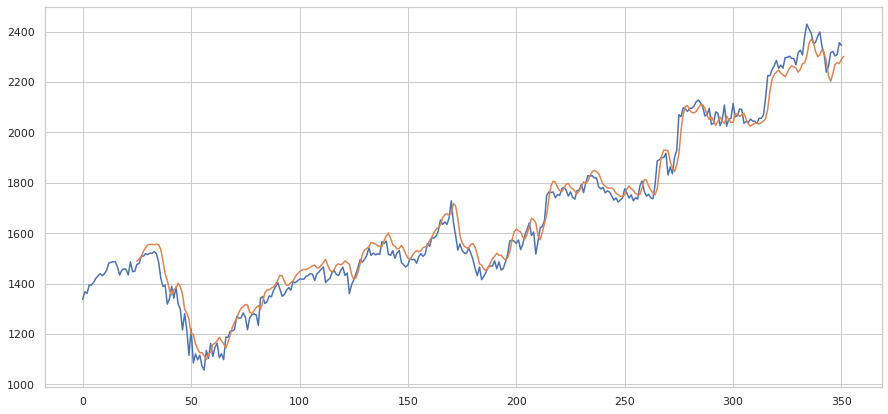

In [130]:
sns.lineplot(x = np.arange(len(data)),y=data)
pred = min_max_scaler.inverse_transform(model.predict(preprocess_data(data))[:,0].reshape(-1,1)).flatten()
sns.lineplot(
    x = np.arange(25,25+len(pred)),
    y = pred)
del pred

### Conv

In [135]:
model = ks.Sequential(
    [
        tf.keras.layers.Input((25,1)),
        tf.keras.layers.Conv1D(128,3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(25, activation='linear',name="dense")
    ]
)

model.compile(loss='mse', optimizer='adam',
                metrics=('mse', 'mae', 'mape'))
model.summary()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    callbacks=(tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                patience=40)),
                    epochs=500,batch_size=16)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 23, 128)           512       
_________________________________________________________________
flatten (Flatten)            (None, 2944)              0         
_________________________________________________________________
dense (Dense)                (None, 25)                73625     
Total params: 74,137
Trainable params: 74,137
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 2s 103ms/step - loss: 0.1207 - mse: 0.1207 - mae: 0.2834 - mape: 2184731.2070 - val_loss: 0.0359 - val_mse: 0.0359 - val_mae: 0.1571 - val_mape: 24.6836
Epoch 2/500
11/11 [==============================] - 0s 7ms/step - loss: 0.0391 - mse: 0.0391 - mae: 0.1712 - mape: 1998622.0312 - val_loss: 0.0273 - val_mse: 0.0273 - val_ma

11/11 [==============================] - 0s 7ms/step - loss: 0.0199 - mse: 0.0199 - mae: 0.0943 - mape: 2050302.1146 - val_loss: 0.0315 - val_mse: 0.0315 - val_mae: 0.1317 - val_mape: 18.3151
Epoch 38/500
11/11 [==============================] - 0s 7ms/step - loss: 0.0220 - mse: 0.0220 - mae: 0.1017 - mape: 2153387.8177 - val_loss: 0.0351 - val_mse: 0.0351 - val_mae: 0.1480 - val_mape: 20.7468
Epoch 39/500
11/11 [==============================] - 0s 7ms/step - loss: 0.0202 - mse: 0.0202 - mae: 0.1078 - mape: 1779546.2604 - val_loss: 0.0124 - val_mse: 0.0124 - val_mae: 0.0823 - val_mape: 12.3159
Epoch 40/500
11/11 [==============================] - 0s 7ms/step - loss: 0.0265 - mse: 0.0265 - mae: 0.1102 - mape: 2891102.6042 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1116 - val_mape: 15.6715
Epoch 41/500
11/11 [==============================] - 0s 7ms/step - loss: 0.0222 - mse: 0.0222 - mae: 0.1016 - mape: 2709357.7083 - val_loss: 0.0376 - val_mse: 0.0376 - val_mae: 0.1537 - val_ma

11/11 [==============================] - 0s 7ms/step - loss: 0.0170 - mse: 0.0170 - mae: 0.0893 - mape: 1811644.1979 - val_loss: 0.0258 - val_mse: 0.0258 - val_mae: 0.1181 - val_mape: 16.4830
Epoch 78/500
11/11 [==============================] - 0s 6ms/step - loss: 0.0191 - mse: 0.0191 - mae: 0.1002 - mape: 1980148.9792 - val_loss: 0.0210 - val_mse: 0.0210 - val_mae: 0.1054 - val_mape: 14.7035
Epoch 79/500
11/11 [==============================] - 0s 6ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0833 - mape: 1407384.9062 - val_loss: 0.0265 - val_mse: 0.0265 - val_mae: 0.1191 - val_mape: 16.5280


In [136]:
models["one_layer_conv"] = model
histories["one_layer_conv"] = history

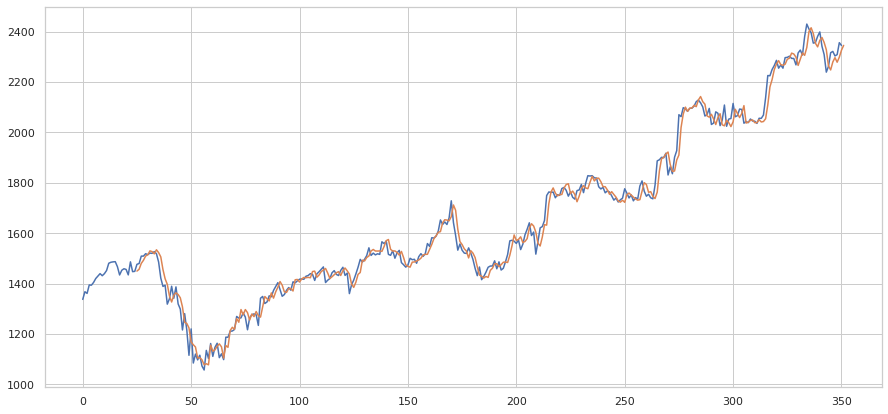

In [137]:
sns.lineplot(x = np.arange(len(data)),y=data)
pred = min_max_scaler.inverse_transform(model.predict(preprocess_data(data))[:,0].reshape(-1,1)).flatten()
sns.lineplot(
    x = np.arange(25,25+len(pred)),
    y = pred)
del pred

# Deep networks

### Simple RNN

In [139]:
model = ks.Sequential(
    [
        tf.keras.layers.Input((25,1)),
        tf.keras.layers.SimpleRNN(128,return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.SimpleRNN(128),
        tf.keras.layers.Dense(25, activation='linear')
    ]
)

model.compile(loss='mse', optimizer='adam',
                metrics=('mse', 'mae', 'mape'))
model.summary()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    callbacks=(tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                patience=40)),
                    epochs=500,batch_size=16)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 25, 128)           16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 128)           0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                3225      
Total params: 52,761
Trainable params: 52,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 2s 52ms/step - loss: 0.2352 - mse: 0.2352 - mae: 0.3652 - mape: 3229494.1875 - val_loss: 0.0485 - val_mse: 0.0485 - val_mae: 0.1669 - val_mape: 24.0708
Epoch 2/500
11/11 [========================

11/11 [==============================] - 0s 27ms/step - loss: 0.0236 - mse: 0.0236 - mae: 0.1171 - mape: 2151999.0104 - val_loss: 0.0321 - val_mse: 0.0321 - val_mae: 0.1431 - val_mape: 20.0188
Epoch 37/500
11/11 [==============================] - 0s 27ms/step - loss: 0.0256 - mse: 0.0256 - mae: 0.1215 - mape: 1861435.0521 - val_loss: 0.0345 - val_mse: 0.0345 - val_mae: 0.1470 - val_mape: 20.5478
Epoch 38/500
11/11 [==============================] - 0s 26ms/step - loss: 0.0224 - mse: 0.0224 - mae: 0.1137 - mape: 1869469.7812 - val_loss: 0.0341 - val_mse: 0.0341 - val_mae: 0.1469 - val_mape: 20.5414
Epoch 39/500
11/11 [==============================] - 0s 27ms/step - loss: 0.0237 - mse: 0.0237 - mae: 0.1152 - mape: 1822325.5573 - val_loss: 0.0372 - val_mse: 0.0372 - val_mae: 0.1510 - val_mape: 20.9207
Epoch 40/500
11/11 [==============================] - 0s 28ms/step - loss: 0.0211 - mse: 0.0211 - mae: 0.1069 - mape: 1937638.3854 - val_loss: 0.0307 - val_mse: 0.0307 - val_mae: 0.1349 - v

In [140]:
models["two_layer_rnn"] = model
histories["two_layer_rnn"] = history

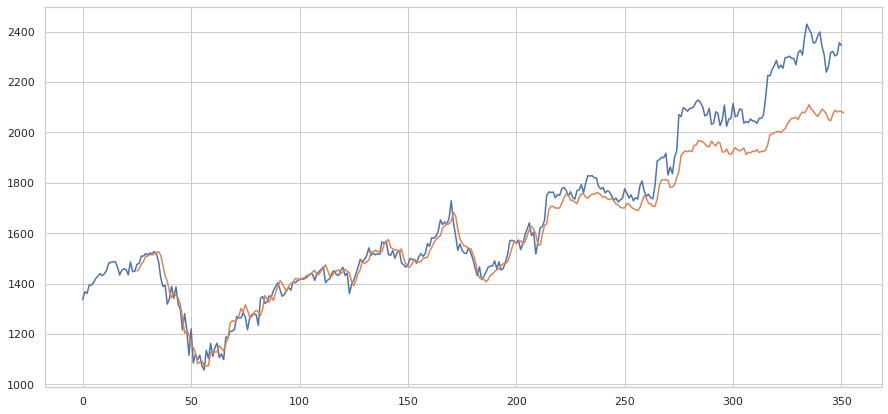

In [141]:
sns.lineplot(x = np.arange(len(data)),y=data)
pred = min_max_scaler.inverse_transform(model.predict(preprocess_data(data))[:,0].reshape(-1,1)).flatten()
sns.lineplot(
    x = np.arange(25,25+len(pred)),
    y = pred)
del pred

### LSTM

In [142]:
model = ks.Sequential(
    [
        tf.keras.layers.Input((25,1)),
        tf.keras.layers.LSTM(128,return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(25, activation='linear')
    ]
)

model.compile(loss='mse', optimizer='adam',
                metrics=('mse', 'mae', 'mape'))
model.summary()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    callbacks=(tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                patience=40)),
                    epochs=500,batch_size=16)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25, 128)           66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 25)                3225      
Total params: 201,369
Trainable params: 201,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 3s 69ms/step - loss: 0.1963 - mse: 0.1963 - mae: 0.3946 - mape: 962893.7546 - val_loss: 0.0712 - val_mse: 0.0712 - val_mae: 0.2311 - val_mape: 33.9911
Epoch 2/500
11/11 [======================

11/11 [==============================] - 0s 14ms/step - loss: 0.0220 - mse: 0.0220 - mae: 0.1028 - mape: 2446923.3542 - val_loss: 0.0213 - val_mse: 0.0213 - val_mae: 0.1071 - val_mape: 14.8366
Epoch 37/500
11/11 [==============================] - 0s 14ms/step - loss: 0.0211 - mse: 0.0211 - mae: 0.1000 - mape: 2231022.1042 - val_loss: 0.0285 - val_mse: 0.0285 - val_mae: 0.1267 - val_mape: 17.2993
Epoch 38/500
11/11 [==============================] - 0s 14ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.0948 - mape: 1895768.9167 - val_loss: 0.0412 - val_mse: 0.0412 - val_mae: 0.1643 - val_mape: 22.9814
Epoch 39/500
11/11 [==============================] - 0s 15ms/step - loss: 0.0217 - mse: 0.0217 - mae: 0.1106 - mape: 2439766.8229 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.0991 - val_mape: 14.1054
Epoch 40/500
11/11 [==============================] - 0s 15ms/step - loss: 0.0219 - mse: 0.0219 - mae: 0.1027 - mape: 2344992.6042 - val_loss: 0.0234 - val_mse: 0.0234 - val_mae: 0.1127 - v

Epoch 76/500
11/11 [==============================] - 0s 15ms/step - loss: 0.0386 - mse: 0.0386 - mae: 0.1303 - mape: 2165214.2292 - val_loss: 0.0496 - val_mse: 0.0496 - val_mae: 0.1653 - val_mape: 22.1000
Epoch 77/500
11/11 [==============================] - 0s 14ms/step - loss: 0.0233 - mse: 0.0233 - mae: 0.1122 - mape: 2341546.9792 - val_loss: 0.0277 - val_mse: 0.0277 - val_mae: 0.1238 - val_mape: 16.5637
Epoch 78/500
11/11 [==============================] - 0s 14ms/step - loss: 0.0225 - mse: 0.0225 - mae: 0.1042 - mape: 2545862.7917 - val_loss: 0.0279 - val_mse: 0.0279 - val_mae: 0.1255 - val_mape: 16.9330
Epoch 79/500
11/11 [==============================] - 0s 14ms/step - loss: 0.0193 - mse: 0.0193 - mae: 0.0963 - mape: 2362070.9896 - val_loss: 0.0315 - val_mse: 0.0315 - val_mae: 0.1353 - val_mape: 18.2891


In [143]:
models["two_layer_lstm"] = model
histories["two_layer_lstm"] = history

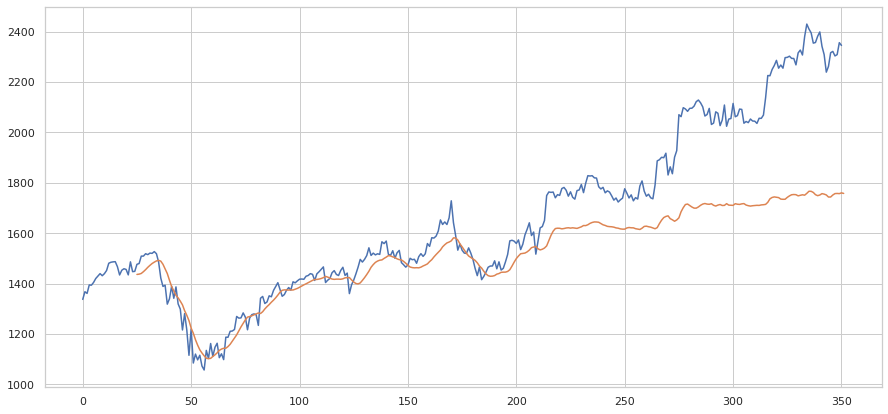

In [144]:
sns.lineplot(x = np.arange(len(data)),y=data)
pred = min_max_scaler.inverse_transform(model.predict(preprocess_data(data))[:,0].reshape(-1,1)).flatten()
sns.lineplot(
    x = np.arange(25,25+len(pred)),
    y = pred)
del pred

### GRU

In [145]:
model = ks.Sequential(
    [
        tf.keras.layers.Input((25,1)),
        tf.keras.layers.GRU(128,return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GRU(128),
        tf.keras.layers.Dense(25, activation='linear')
    ]
)

model.compile(loss='mse', optimizer='adam',
                metrics=('mse', 'mae', 'mape'))
model.summary()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    callbacks=(tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                patience=40)),
                    epochs=500,batch_size=16)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 25, 128)           50304     
_________________________________________________________________
dropout_3 (Dropout)          (None, 25, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_3 (Dense)              (None, 25)                3225      
Total params: 152,601
Trainable params: 152,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 3s 61ms/step - loss: 0.1731 - mse: 0.1731 - mae: 0.3700 - mape: 641393.2161 - val_loss: 0.0247 - val_mse: 0.0247 - val_mae: 0.1187 - val_mape: 19.2264
Epoch 2/500
11/11 [======================

11/11 [==============================] - 0s 13ms/step - loss: 0.0194 - mse: 0.0194 - mae: 0.1023 - mape: 1846118.2500 - val_loss: 0.0210 - val_mse: 0.0210 - val_mae: 0.1057 - val_mape: 14.8423
Epoch 37/500
11/11 [==============================] - 0s 13ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.1003 - mape: 2406695.6250 - val_loss: 0.0270 - val_mse: 0.0270 - val_mae: 0.1290 - val_mape: 17.9949
Epoch 38/500
11/11 [==============================] - 0s 13ms/step - loss: 0.0178 - mse: 0.0178 - mae: 0.0983 - mape: 1949261.7396 - val_loss: 0.0221 - val_mse: 0.0221 - val_mae: 0.1087 - val_mape: 15.1845
Epoch 39/500
11/11 [==============================] - 0s 13ms/step - loss: 0.0176 - mse: 0.0176 - mae: 0.0924 - mape: 1736069.1042 - val_loss: 0.0335 - val_mse: 0.0335 - val_mae: 0.1491 - val_mape: 21.1708
Epoch 40/500
11/11 [==============================] - 0s 13ms/step - loss: 0.0237 - mse: 0.0237 - mae: 0.1191 - mape: 2322707.4896 - val_loss: 0.0163 - val_mse: 0.0163 - val_mae: 0.0961 - v

In [146]:
models["two_layer_c"] = model
histories["two_layer_gru"] = history

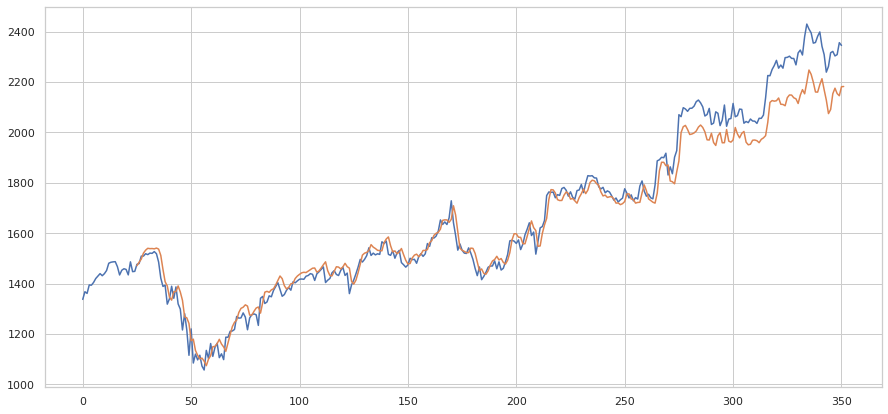

In [147]:
sns.lineplot(x = np.arange(len(data)),y=data)
pred = min_max_scaler.inverse_transform(model.predict(preprocess_data(data))[:,0].reshape(-1,1)).flatten()
sns.lineplot(
    x = np.arange(25,25+len(pred)),
    y = pred)
del pred

### Conv

In [150]:
model = ks.Sequential(
    [
        tf.keras.layers.Input((25,1)),
        tf.keras.layers.Conv1D(128,3),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(128,3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(25, activation='linear')
    ]
)

model.compile(loss='mse', optimizer='adam',
                metrics=('mse', 'mae', 'mape'))
model.summary()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    callbacks=(tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                patience=40)),
                    epochs=500,batch_size=16)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 23, 128)           512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 23, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 21, 128)           49280     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2688)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 25)                67225     
Total params: 117,017
Trainable params: 117,017
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 3s 153ms/step - loss: 0.1158 - mse: 0.1158 - mae: 0.2841 - m

11/11 [==============================] - 0s 7ms/step - loss: 0.0197 - mse: 0.0197 - mae: 0.0962 - mape: 2298022.1146 - val_loss: 0.0198 - val_mse: 0.0198 - val_mae: 0.1020 - val_mape: 14.3260
Epoch 37/500
11/11 [==============================] - 0s 8ms/step - loss: 0.0188 - mse: 0.0188 - mae: 0.0934 - mape: 2027688.0521 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.0977 - val_mape: 13.8421
Epoch 38/500
11/11 [==============================] - 0s 8ms/step - loss: 0.0208 - mse: 0.0208 - mae: 0.1003 - mape: 2133227.1250 - val_loss: 0.0242 - val_mse: 0.0242 - val_mae: 0.1132 - val_mape: 15.7338
Epoch 39/500
11/11 [==============================] - 0s 8ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.0927 - mape: 1595079.0026 - val_loss: 0.0226 - val_mse: 0.0226 - val_mae: 0.1089 - val_mape: 15.1361
Epoch 40/500
11/11 [==============================] - 0s 8ms/step - loss: 0.0170 - mse: 0.0170 - mae: 0.0906 - mape: 1605920.5625 - val_loss: 0.0272 - val_mse: 0.0272 - val_mae: 0.1218 - val_ma

11/11 [==============================] - 0s 7ms/step - loss: 0.0162 - mse: 0.0162 - mae: 0.0895 - mape: 1555776.5260 - val_loss: 0.0197 - val_mse: 0.0197 - val_mae: 0.1014 - val_mape: 14.4192
Epoch 77/500
11/11 [==============================] - 0s 8ms/step - loss: 0.0183 - mse: 0.0183 - mae: 0.0970 - mape: 1680922.9688 - val_loss: 0.0333 - val_mse: 0.0333 - val_mae: 0.1404 - val_mape: 19.6370
Epoch 78/500
11/11 [==============================] - 0s 8ms/step - loss: 0.0192 - mse: 0.0192 - mae: 0.1027 - mape: 1460312.2839 - val_loss: 0.0343 - val_mse: 0.0343 - val_mae: 0.1417 - val_mape: 19.6931
Epoch 79/500
11/11 [==============================] - 0s 8ms/step - loss: 0.0212 - mse: 0.0212 - mae: 0.1052 - mape: 1862278.4479 - val_loss: 0.0215 - val_mse: 0.0215 - val_mae: 0.1053 - val_mape: 14.7006
Epoch 80/500
11/11 [==============================] - 0s 8ms/step - loss: 0.0147 - mse: 0.0147 - mae: 0.0852 - mape: 1564226.4375 - val_loss: 0.0289 - val_mse: 0.0289 - val_mae: 0.1286 - val_ma

In [151]:
models["two_layer_conv"] = model
histories["two_layer_conv"] = history

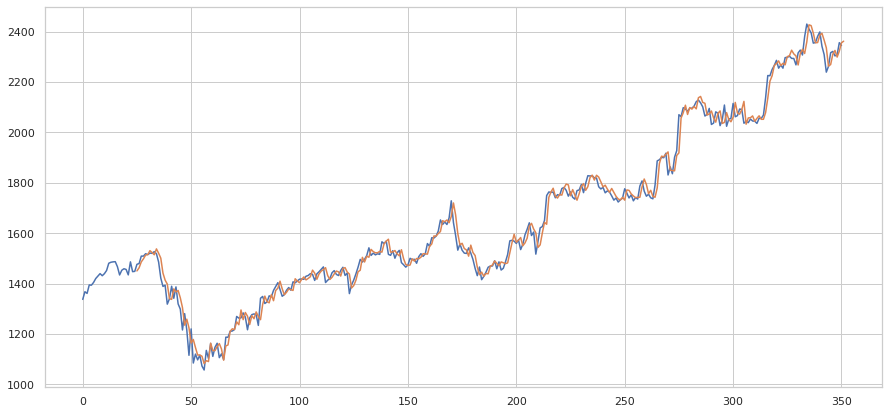

In [152]:
sns.lineplot(x = np.arange(len(data)),y=data)
pred = min_max_scaler.inverse_transform(model.predict(preprocess_data(data))[:,0].reshape(-1,1)).flatten()
sns.lineplot(
    x = np.arange(25,25+len(pred)),
    y = pred)
del pred

# Result analysis

In [158]:
X_test_25 = preprocess_data(data[:training_len])

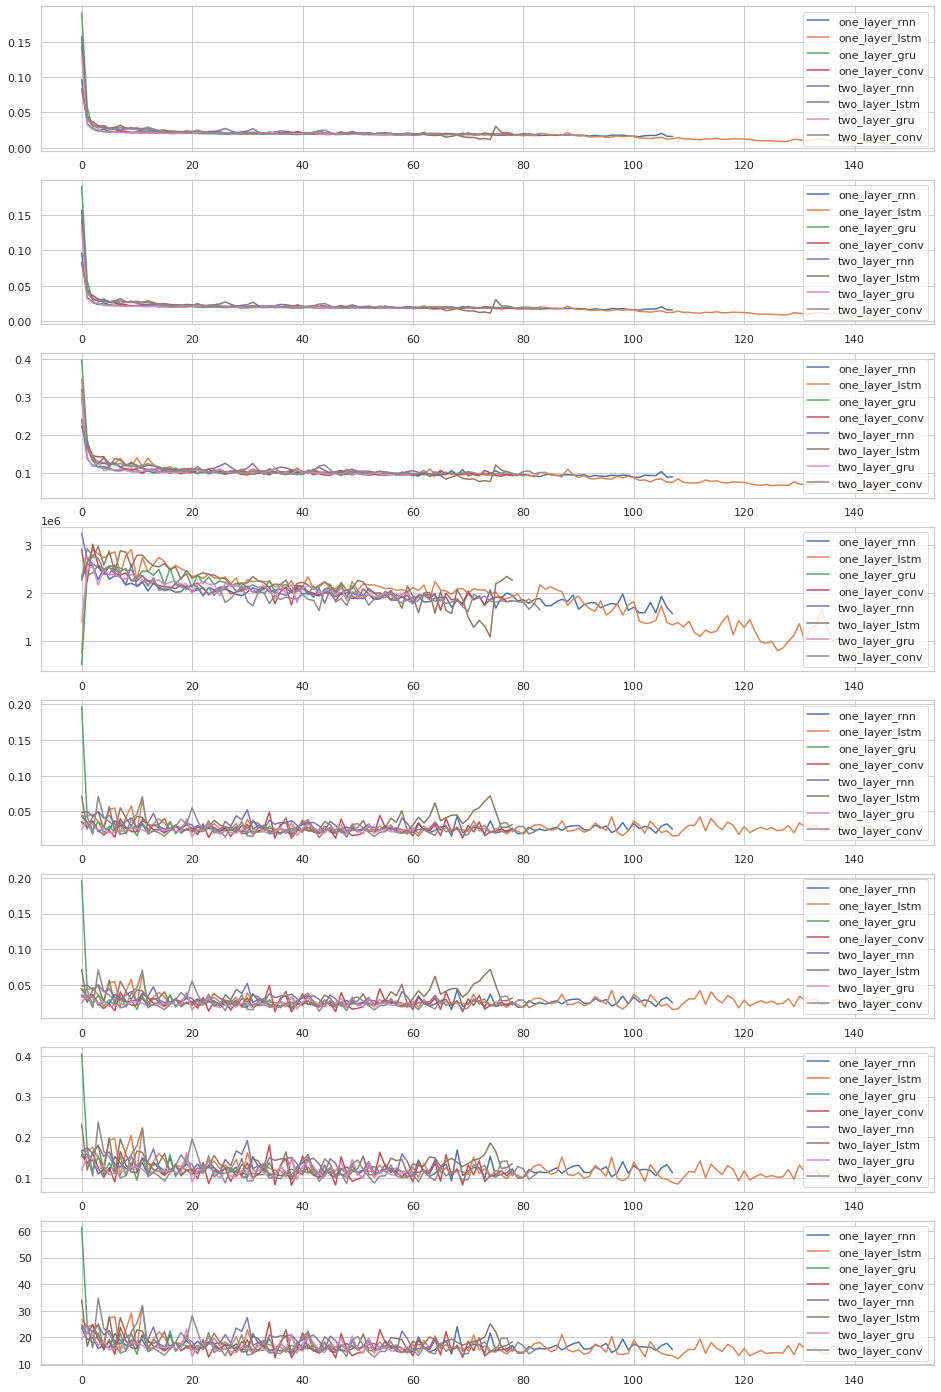

In [177]:
metrics_names = histories["one_layer_conv"].history.keys()
fig, axes = plt.subplots(len(metrics_names), 1, figsize=(16, 25))
for model_name, his in histories.items():
    for i,metric_name in enumerate(metrics_names):
        axes[i].plot(his.history[metric_name], label=model_name)
        axes[i].legend()
plt.show()

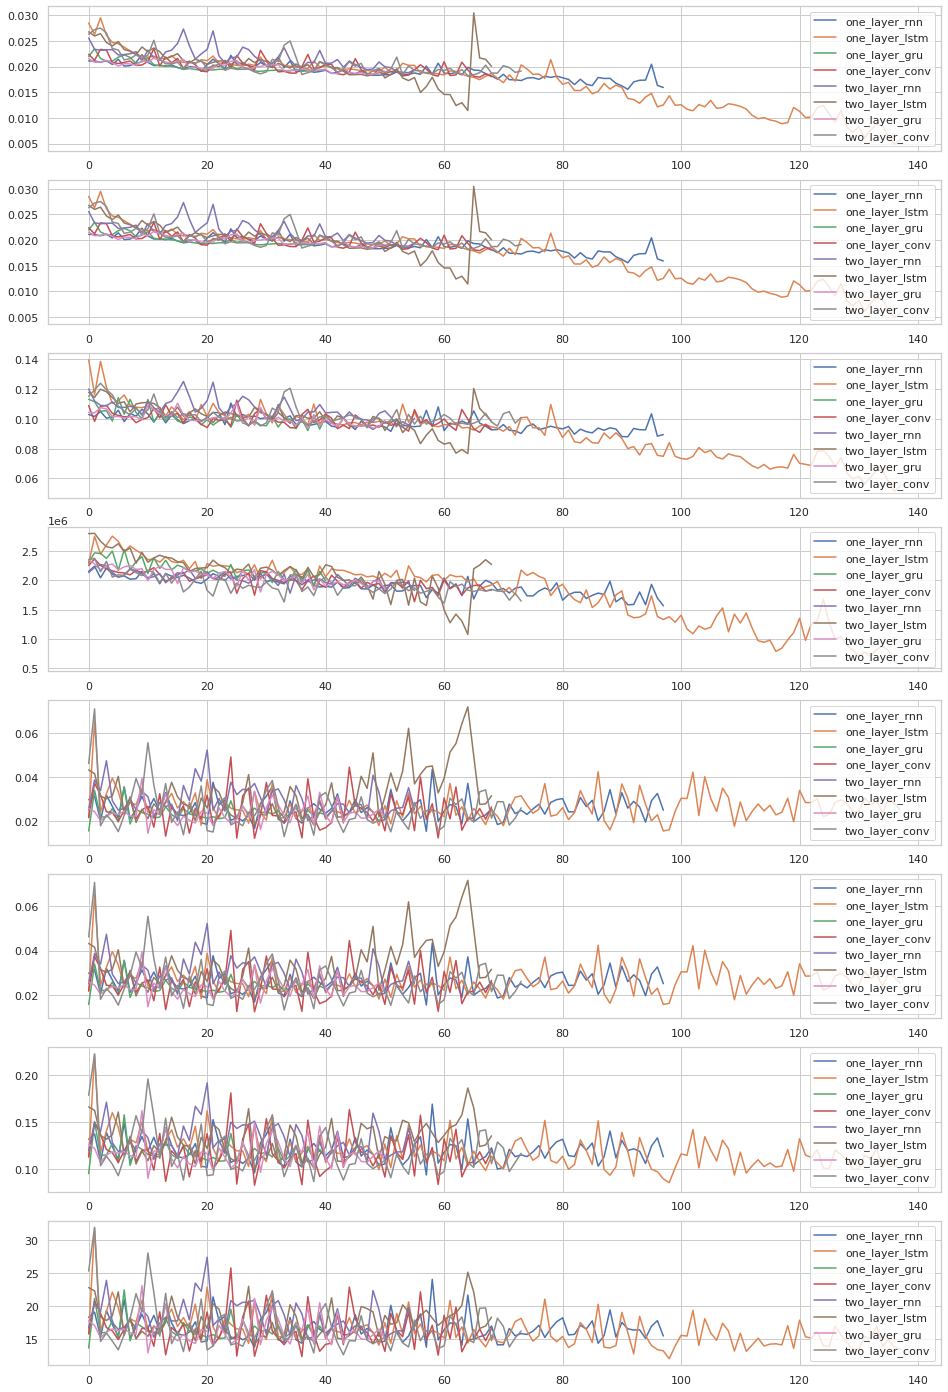

In [179]:
metrics_names = histories["one_layer_conv"].history.keys()
fig, axes = plt.subplots(len(metrics_names), 1, figsize=(16, 25))
for model_name, his in histories.items():
    for i,metric_name in enumerate(metrics_names):
        axes[i].plot(his.history[metric_name][10:], label=model_name)
        axes[i].legend()
plt.show()